# Evaluating SETI detection performance - plots of parameter sweeps over multiple raw files
This notebook takes the stored outputs of notebook "02_seti_param_sweep.ipynb", in the form of numpy npz files, and
plots detection SNR and timing information.

Runs of interest may include:
1) Examining the effect of non-coherent averaging time on SNR, with synthetic raw files of varying duration
2) Examining run time improvements over branches for the same fine FFT size and integration factor n_sti

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import array
%matplotlib inline
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

import src.plot_fns as pltg             # generic plot fns
import src.plot_h5_psd_sg1 as plt_h5    # blimpy-based plot fns

do_snr_drift_plot = False
do_snr_time_plot = False

if (0):
    npz_dir = './chirp_gbt_plots/compare_sc012/'
    fig_dir = './chirp_gbt_plots/'
    do_snr_drift_plot = True
    npz_file_root_list = [
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec',
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec',
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-91.63sec',
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-183.25sec']
    test_case_list = ['sc0','sc1','sc2']
    fine_fft_size = 1024*1024
    n_sti = 2
    f_center = 6e9
elif (1):
    npz_dir = './chirp_gbt_plots/compare_sc012/'
    fig_dir = './chirp_gbt_plots/'
    do_snr_time_plot = True
    npz_file_root_list = [
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec',
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec',
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-91.63sec',
        'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-183.25sec']
    test_case_list = ['sc1','sc2']
    fine_fft_size = 1024*1024
    n_sti = 2
    f_center = 6e9



#### Read npz files from each run

In [2]:
n_npz_root = len(npz_file_root_list)
n_test_case = len(test_case_list)
n_file = n_npz_root*n_test_case

i_file = 0
z_data = [];

for i_test_case in range(n_test_case):
    for i_root in range(n_npz_root):

        npz_file = npz_dir + npz_file_root_list[i_root] + '-' + test_case_list[i_test_case] + '.npz'
        print(f'\n\nNPZ file {i_file+1} of {n_file}: {npz_file}\n\n')

        z_data1 = np.load(npz_file)
        z_data.append(z_data1)

        # print(z_data1.files)
        # print(z_data1['test_case'])
        # print(z_data1['fine_fft_size_list'])
        # print(z_data1['n_sti_list'])
        # print(z_data1['n_lti_list'])
        # print(f'T_avg_list=')
        # print(z_data1['T_avg_list'])
        # print(f'snr_core_db_wavg_all=')
        # print(z_data1['snr_core_db_wavg_all'])
        # print(f"drift_rate_core_all shape= {z_data1['drift_rate_core_all'].shape}")
        # # print(f'snr_core_db_all=')
        # # print(z_data1['snr_core_db_all'])
    
        i_file += 1
    
# Assume all cases have same shapes
det_shape = z_data1['drift_rate_core_all'].shape
n_det_max = det_shape[0]
len_n_fft_list = len(z_data1['fine_fft_size_list'])
len_n_sti_list = len(z_data1['n_sti_list'])
print(f'{det_shape=}, {n_det_max=}, {len_n_fft_list=}, {len_n_sti_list=}')
search_max_drift = z_data1['search_max_drift'].tolist()
search_min_drift = z_data1['search_min_drift'].tolist()
print(f'{search_min_drift=}, {search_max_drift=}')
f_sigma_drift = z_data1['f_sigma_drift']
sigma_drift = z_data1['sigma_drift']
print(f'{f_sigma_drift=}, {sigma_drift=}')



NPZ file 1 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec-sc1.npz




NPZ file 2 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec-sc1.npz




NPZ file 3 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-91.63sec-sc1.npz




NPZ file 4 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-183.25sec-sc1.npz




NPZ file 5 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec-sc2.npz




NPZ file 6 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec-sc2.npz




NPZ file 7 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-91.63sec-sc2.npz




NPZ file 8 of 8: ./chirp_gbt_plots/compare_sc012/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-183.25sec-sc2.npz


det_shape=(200

#### Do a multirun detection plot 

In [3]:
%matplotlib inline

if do_snr_drift_plot:
    fine_fft_size_K = fine_fft_size/1024
    i_file = 0

    for i_test_case in range(n_test_case):

        drift_rate_plot = np.ones((n_det_max,n_npz_root))*np.nan
        snr_db_plot = np.ones((n_det_max,n_npz_root))*np.nan
        n_lti_plot = np.ones((n_npz_root))*np.nan
        n_avg_plot = np.ones((n_npz_root))*np.nan
        T_avg_plot = np.ones((n_npz_root))*np.nan
        test_case_plot = test_case_list[i_test_case]
        plot_legend = ['']*n_npz_root

        for i_root in range(n_npz_root):
            z_data1 = z_data[i_file]
            i_fft  = np.where(z_data1['fine_fft_size_list']==fine_fft_size)[0][0]
            i_sti = np.where(z_data1['n_sti_list']==n_sti)[0][0]
        
            drift_rate_plot[:,i_root] = z_data1['drift_rate_core_all'][:,i_fft,i_sti]
            snr_db_plot[:,i_root] = z_data1['snr_core_db_all'][:,i_fft,i_sti]
            n_lti_plot[i_root] = z_data1['n_lti_list'][i_fft,i_sti]
            n_avg_plot[i_root] = n_sti*n_lti_plot[i_root]
            T_avg_plot[i_root] = z_data1['T_avg_list'][i_fft,0]
            
            i_file +=1
        
            plot_legend[i_root] = f'{fine_fft_size_K:.0f}K, {n_sti=:2d}, n_lti={n_lti_plot[i_root]:3.0f}, T_avg={T_avg_plot[i_root]:5.1f} sec'
            print(plot_legend[i_root])

        pltg.plot_generic(x_data=drift_rate_plot,
                y_data=snr_db_plot,
                xy_markers = '*',
                xy_legend = plot_legend,
                x_limits=[search_min_drift-1,search_max_drift+1],
                y_limits=[15., 45.],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                # fig_title= telescope.upper() + f' Seticore Detection SNR over Multiple Averaging Durations  '+test_case_plot,  
                fig_title= f' Seticore Detection SNR over Multiple Averaging Durations  '+test_case_plot,   # TEMP
                fig_text_list=[[.15,.12,npz_file_root_list[0]]],
                legend_loc = 'upper right',
                display_fig=True,
                savfig_name=fig_dir + '30-' + npz_file_root_list[0] + f'-FineFFT-{fine_fft_size_K:.0f}K' + f'-Nsti-{n_sti}' + '-seticore-det-'+test_case_plot+'.png')


#### Plot composite results: SNR vs Drift Rate


Test Case sc1
Test Case sc2


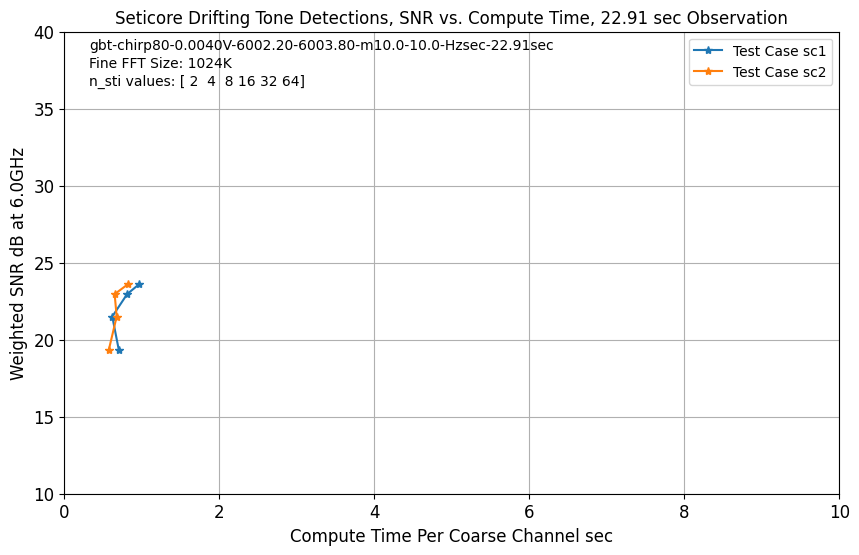

Test Case sc1
Test Case sc2


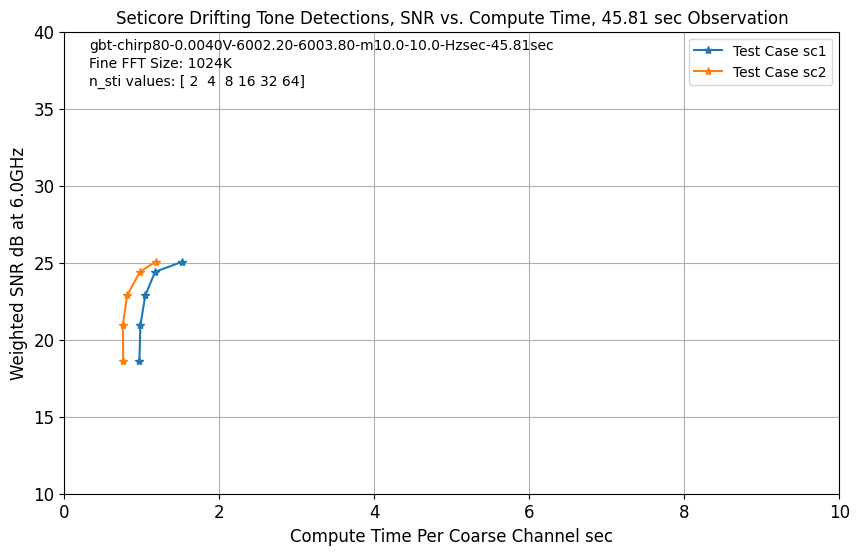

Test Case sc1
Test Case sc2


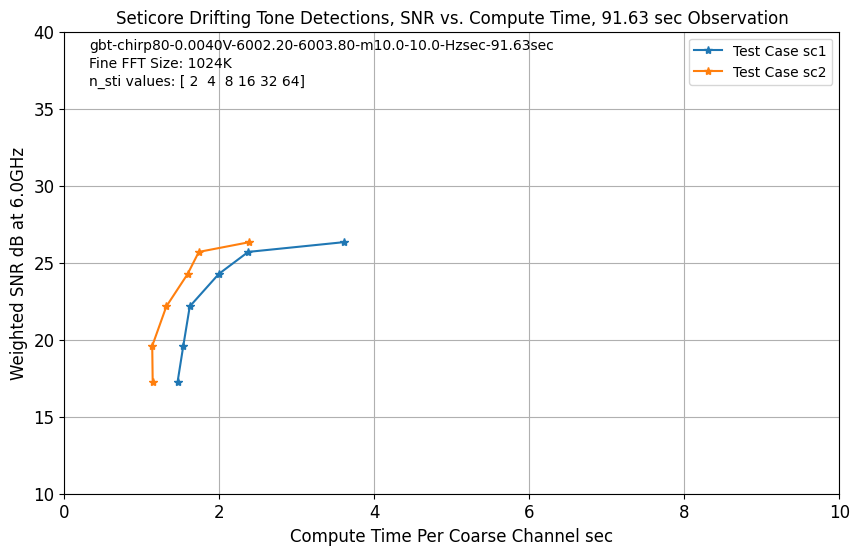

Test Case sc1
Test Case sc2


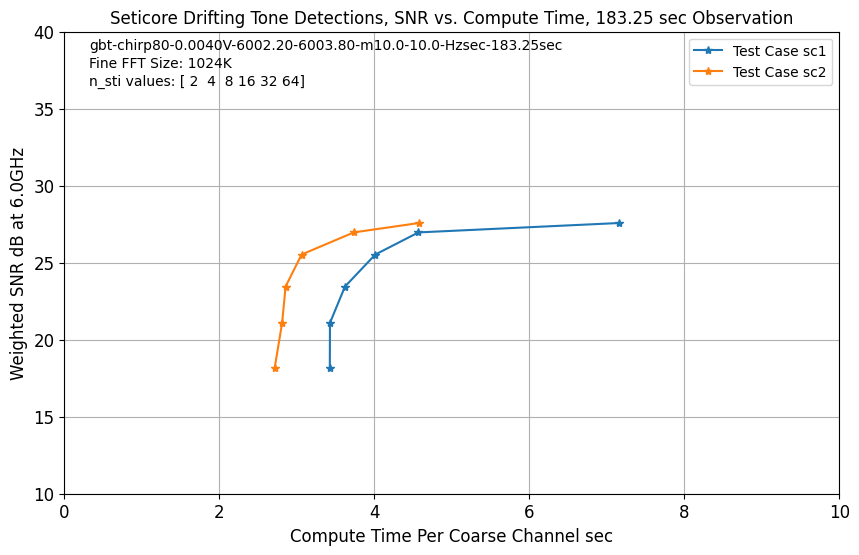

In [4]:
if do_snr_time_plot:
    fine_fft_size_K = fine_fft_size/1024
    i_f_center = np.where(f_sigma_drift==f_center)[0][0]
            
    t_comp_plot = np.ones((len_n_sti_list,n_test_case))*np.nan
    snr_wavg_db_plot = np.ones((len_n_sti_list,n_test_case))*np.nan
    T_avg_plot = np.ones((n_npz_root))*np.nan
    plot_legend = ['']*n_test_case

    for i_root in range(n_npz_root):
        for i_test_case in range(n_test_case):
            i_file = i_test_case*n_npz_root + i_root
            z_data1 = z_data[i_file]
            i_fft  = np.where(z_data1['fine_fft_size_list']==fine_fft_size)[0][0]
            test_case_plot = test_case_list[i_test_case]
        
            t_comp_plot[:,i_test_case] = z_data1['time_core_total'][i_fft,:].T
            snr_wavg_db_plot[:,i_test_case] = z_data1['snr_core_db_wavg_all'][i_fft,:,i_f_center]
            T_avg_plot[i_root] = z_data1['T_avg_list'][i_fft,0]
            n_sti_list = z_data1['n_sti_list']

            plot_legend[i_test_case] = f'Test Case {test_case_plot}'
            print(plot_legend[i_test_case])

        xlim_max = 2.*np.ceil(np.nanmax(t_comp_plot[:]/2.))
        if (xlim_max<10.): xlim_max=10.;


        pltg.plot_generic(x_data=t_comp_plot,
                y_data=snr_wavg_db_plot,
                xy_markers = '-*',
                xy_legend = plot_legend,
                x_limits=[0,xlim_max],
                y_limits=[10., 40.],
                x_label = 'Compute Time Per Coarse Channel sec',
                y_label = f'Weighted SNR dB at {f_center*1e-9:.1f}GHz',
                fig_title= f'Seticore Drifting Tone Detections, SNR vs. Compute Time, {T_avg_plot[i_root]:.2f} sec Observation',
                fig_text_list=[[.15,.85,npz_file_root_list[i_root]],
                            [.15,.82,f'Fine FFT Size: {fine_fft_size_K:.0f}K'],
                            [.15,.79,f'n_sti values: '+ np.array2string(n_sti_list,precision=0)]],
                legend_loc = 'upper right',
                display_fig=True,
                savfig_name=fig_dir + '31-' + npz_file_root_list[i_root] + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-seticore-det-'+test_case_list[0]+'.png')

        # write results to csv file
        text_file_name = fig_dir + '32-' + npz_file_root_list[i_root] + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-seticore-det-'+test_case_list[0]+'.txt'
        f = open(text_file_name,'w')
        f.write(f'Fine FFT Size: {fine_fft_size_K:.0f}K, {T_avg_plot[i_root]:.2f} sec Observation \n')
        f.write(f'Nsti')
        for i_test_case, test_case in enumerate(test_case_list):
            f.write(f' \t{test_case}')
        for i_test_case, test_case in enumerate(test_case_list):
            f.write(f' \t{test_case}')
        f.write(f'\n')
        for i_test_case, test_case in enumerate(test_case_list):
            f.write(f' \tSec')
        for i_test_case, test_case in enumerate(test_case_list):
            f.write(f' \tSNR dB')
        f.write(f'\n')
        for i_sti, n_sti in enumerate(n_sti_list):
            f.write(f'{n_sti}')
            for i_test_case in range(n_test_case):
                f.write(f' \t{t_comp_plot[i_sti,i_test_case]:.2f}')
            for i_test_case in range(n_test_case):
                f.write(f' \t{snr_wavg_db_plot[i_sti,i_test_case]:.2f}')
            f.write(f'\n')
        f.close()

    

In [5]:
import os

print('All Runs Done')

# Beep 2 times in WSL
os.system("powershell.exe '[console]::beep(261.6,700)'")
os.system("powershell.exe '[console]::beep(261.6,700)'")


All Runs Done


0